<h1 align="center">INET4061 Project</h1>
<h1 align="center">Facial Recognition: identifying name and emotion</h1>
<h3 align="center">Ruoyun Chen, Yangjiawen Xu</h3>
<h3 align="center">Nov 30, 2018</h3>

## Overview

In this project, we use the dataset 'the labled face in the wild' to identify the name and use the JAFFE dataset and labeled face in the wild to facial expression recognition.

The fist task of face recognition in this project is identifying a person from an image of the person's face. This can be treated as a classification problem where we assign the person's name to an image of a face.

To identify the name,
- Preprocessing data with PCA
- Train a SVM model
- Hyper-parameters tuning using a Cross-Validated Grid Search
- Plot the images on test set
- Evaluation

The second task of face recognition is to identify a person's emotions.This can also be treated as a classification problem where we assign the person's emotion to an image of a face. 

To identify the emotions,
- Preprocess data 
- Use representational autoencoder units to classify an image among one of the seven different emotions
- Create CNN Layer Set
- Train on the JAFFE dataset
- Test on the labeled faces in the wild dataset
- Evaluation

Reference:
+ https://github.com/orlandopython/ML-Workshop/blob/09af4cf135a77b5397f3ea532ddf8d2b3950b46a/Eigen%20Faces.ipynb
+ http://nbviewer.jupyter.org/github/ogrisel/notebooks/blob/master/Labeled%20Faces%20in%20the%20Wild%20recognition.ipynb
+ https://github.com/pckuo/hands_on_ML/blob/bb07420d5f3e6686157ed3ea683d5dffbc6cf281/exercise/ex07_application_to_face_recognition.ipynb
+ 
https://github.com/ashishpatel26/Facial-Expression-Recognization-using-JAFFE
+ 
https://github.com/nicolascerna/emotion-recognition-example

Data Source:
+ http://vis-www.cs.umass.edu/lfw/#information
+ http://www.kasrl.org/jaffe.html

In [14]:
%pylab inline

import pylab as pl
import numpy as np
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import keras

from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Data
Labeled Faces in the Wild is a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. More details can be found in http://vis-www.cs.umass.edu/lfw.

We use a subset of this dataset to identify face.

Here is the data of Labeled Faces in the Wild. 

In [9]:
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')
lfw_people.data.shape


(1288, 1850)

In [10]:

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
print("image shape: h={0}, w={1}".format(h,w))
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

image shape: h=50, w=37
n_samples: 1288
n_features: 1850
n_classes: 7


n_classes is the number of distinct names.

Visualize these faces: 

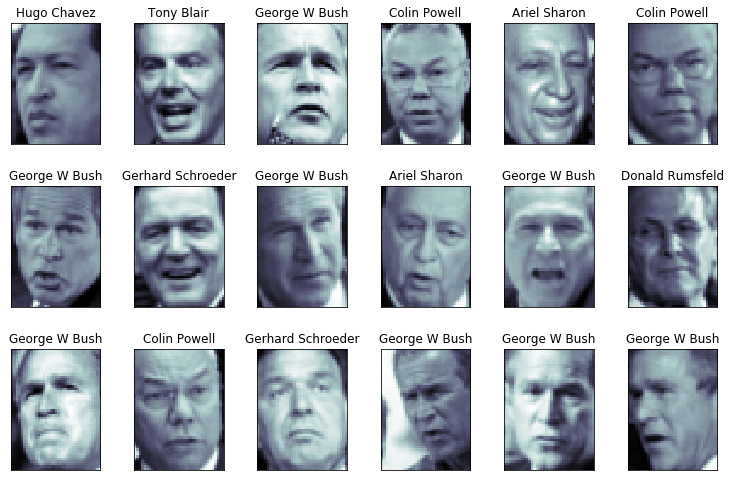

In [11]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.bone)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

JAFFE is the database which contains 213 images of 7 facial expressions (6 basic facial expressions + 1 neutral) posed by 10 Japanese female models. Each image has been rated on 6 emotion adjectives by 60 Japanese subjects. More details can be found in http://www.kasrl.org/jaffe.html.

Here is the data of JAFFE.

In [24]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

## Exploratory Data Analysis

In [ ]:

pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

We'll do a typical train-test split on the images to make this happen:

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=0)

print(X_train.shape, X_test.shape)


1850 dimensions is a lot for SVM. We can use PCA to reduce these 1850 features to a manageable size, while maintaining most of the information in the dataset. Here it is useful to use a variant of PCA called RandomizedPCA, which is an approximation of PCA that can be much faster for large datasets. The interface is the same as the normal PCA we saw earlier. 
The reason we chose PCA "eigenfaces" as a pre-processing step is because PCA is a broadly-applicable technique, which can be useful for a wide array of data types. Research in the field of facial recognition in particular, however, has shown that other more specific feature extraction methods are can be much more effective.

In [ ]:
from sklearn import decomposition
pca = decomposition.RandomizedPCA(n_components=150, whiten=True)
pca.fit(X_train)

plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)
eigenfaces = pca.components_.reshape((150, 50, 37))

One interesting part of PCA is that it computes the "mean" face.
The principal components measure deviations about this mean along orthogonal axes. It is also interesting to visualize these principal components:

In [ ]:
print(pca.components_.shape)

In [ ]:
eigen_title=['eigenface']*18
plot_gallery(eigenfaces,eigen_title, 50, 37)

The components ("eigenfaces") are ordered by their importance from top-left to bottom-right. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training and test data onto the PCA basis:

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)


These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face.

## Models
### Training a Gaussian Kernel SVM
We'll perform support-vector-machine classification on this reduced dataset:

In [ ]:
from sklearn import svm
clf1 = svm.SVC(C=5., gamma=0.001)
t0 = time.time()
clf1.fit(X_train_pca, y_train)

In [ ]:
print("done in {0:.3f}s".format(time.time() - t0))

In [ ]:
fig = plt.figure(figsize=(8, 6))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=1.20, hspace=.35)
for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf1.predict(X_test_pca[i].reshape(1,-1))[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    title = '%s\npredicted:\n %s' % (names[y_test[i]],lfw_people.target_names[y_pred])
    ax.set_title(title, fontsize='small', color=color)

How did our model do? We'll use two matrix reports to show how accurate our model was for each target. Some quick vocab for the first report:

- Accuracy: How many targets were identified corrently
- Precision: How many positive results were actually positive (or low false positives)
- Recall: How many negative results were actually negative (or low true negatives)
- F1-score: Combined score favoring Precision
- F2-score: Combined score favoring Recall

In [ ]:
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print("Predicting the people names on the testing set")
t0 = time.time()
y_pred = clf1.predict(X_test_pca)
print("done in {0:.3f}s".format(time.time() - t0))

print(classification_report(y_test, y_pred, target_names=names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score

cv = StratifiedShuffleSplit(y_train, test_size=0.20, n_iter=3)

%time svm_cv_scores = cross_val_score(svm, X_train_pca, y_train, scoring='f1', n_jobs=2)
svm_cv_scores

### Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

Now that our data is more manageable after computing the eigen vectors, we can feed it into a Support Vector Machine to do the classification. We're going to use a feature of sk-learn called GridSearchCV to find the optimal parameter settings rather than tuning them ourselves. We still have to supply potential settings, but it will figure out the best tuning with what we give it.



In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf2 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
# clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=2)
# clf = clf.fit(X_train_pca, y_train)
# print("done in {0:.3f}s".format(time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

In [ ]:
t0 = time.time()
clf2 = clf2.fit(X_train_pca, y_train)
print("done in {0:.3f}s".format(time.time() - t0))

In [ ]:
print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

In [ ]:
fig = plt.figure(figsize=(8, 6))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=1.20, hspace=.35)
for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf2.predict(X_test_pca[i].reshape(1,-1))[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    title = '%s\npredicted:\n %s' % (names[y_test[i]],lfw_people.target_names[y_pred])
    ax.set_title(title, fontsize='small', color=color)

In [ ]:
print("Predicting the people names on the testing set")
t0 = time.time()
y_pred2 = clf2.predict(X_test_pca)
print("done in {0:.3f}s".format(time.time() - t0))

print(classification_report(y_test, y_pred2, target_names=names))
print(confusion_matrix(y_test, y_pred2, labels=range(n_classes)))

## Conclusions

## Part II

In [3]:
#Define Datapath
data_path = './jaffe/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    if dataset != '.DS_Store':
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            if img != '.DS_Store':
                im_path = data_path + dataset + '/'+ img
                input_img=cv2.imread(im_path)
                #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                input_img_resize=cv2.resize(input_img,(128,128))
                img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-HAPPY

Loaded the images of dataset-SAD

Loaded the images of dataset-FEAR

Loaded the images of dataset-SURPRISE

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-ANGRY

Loaded the images of dataset-DISGUST



(213, 128, 128, 3)

In [4]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]



In [5]:
# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

In [6]:
# Defining the model

input_shape=img_data[0].shape

model = Sequential()

# Feature Extraction
# model.add(Convolution2D(32,3,3, border_mode='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(Convolution2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Convolution2D(64, 3, 3))
# model.add(Activation('relu'))
# # model.add(Convolution2D(64, 3, 3))
# # model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Convolution2D(128, 3, 3))
# model.add(Activation('relu'))
# # model.add(Convolution2D(128, 3, 3))
# # model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

#new Code
model.add(Convolution2D(6, 5, 5, input_shape=input_shape, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(120, 5, 5))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Classification
# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [7]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 6)       456       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 6)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 120)       48120     
__________

True

In [8]:
from keras import callbacks
filename='model_train_new.csv'
filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

In [9]:
# Training
hist = model.fit(X_train, y_train, batch_size=7, nb_epoch=30, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)

Train on 181 samples, validate on 32 samples
Epoch 1/30
181/181 [==============================] - 8s 47ms/step - loss: 2.7416 - acc: 0.1215 - val_loss: 1.9577 - val_acc: 0.0938
Epoch 2/30
181/181 [==============================] - 7s 37ms/step - loss: 1.9417 - acc: 0.1436 - val_loss: 1.9746 - val_acc: 0.1250
Epoch 3/30
181/181 [==============================] - 7s 37ms/step - loss: 1.9188 - acc: 0.1989 - val_loss: 1.8908 - val_acc: 0.2813
Epoch 4/30
181/181 [==============================] - 6s 35ms/step - loss: 1.8535 - acc: 0.2431 - val_loss: 1.9423 - val_acc: 0.1250
Epoch 5/30
181/181 [==============================] - 6s 35ms/step - loss: 1.7909 - acc: 0.2652 - val_loss: 1.8559 - val_acc: 0.2813
Epoch 6/30
181/181 [==============================] - 6s 36ms/step - loss: 1.7138 - acc: 0.3370 - val_loss: 1.7809 - val_acc: 0.2813
Epoch 7/30
181/181 [==============================] - 7s 38ms/step - loss: 1.5020 - acc: 0.4420 - val_loss: 1.8171 - val_acc: 0.1875
Epoch 8/30
181/181 [====

<Figure size 432x288 with 0 Axes>

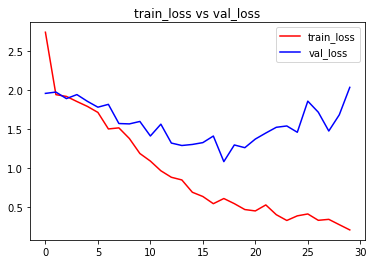

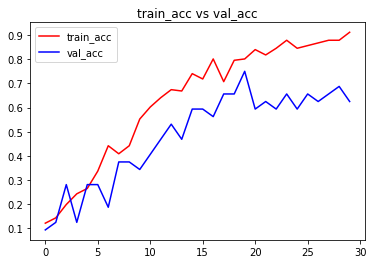

<Figure size 432x288 with 0 Axes>

In [11]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

Test Loss: 2.0350475311279297
Test accuracy: 0.625
(1, 128, 128, 3)
[[5.1144161e-04 7.0107070e-04 6.4481919e-06 4.4819255e-05 9.9873334e-01
  4.9082752e-07 2.3680100e-06]]
[4]
[[0. 0. 0. 0. 1. 0. 0.]]


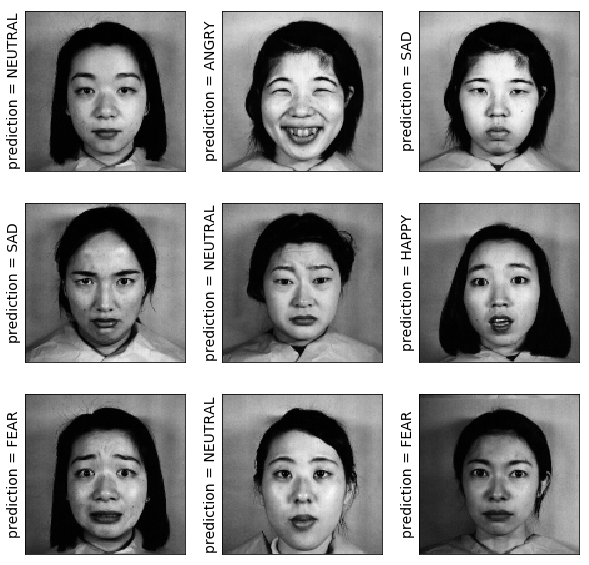

In [12]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

res = model.predict_classes(X_test[:9])
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()

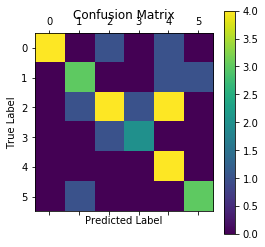

In [13]:
from sklearn.metrics import confusion_matrix
results = model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()